<a href="https://colab.research.google.com/github/solarslurpi/GrowBuddies/blob/main/growbuddiesproject/growbuddies/drgrowbuddy/data_preprocessing_learnings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Preprocessing Learnings
I am working on the Dr. GrowBuddy project.  The goal of Dr. GrowBuddy is to take in images (and eventually text?) and from that, determine what is wrong with the (Cannabis) plant.

To do this, I'll be using Deep Learning.  I decided to use the PyTorch library.  I had been evaluating TensorFlow.  However, I found PyTorch far more intuitive and it seems like most data scientists feel the same way since PyTorch has grown in popularity whereas TensorFlow has not.

The notebook is about getting images that will be used during Deep Learning into a PyTorch Dataset.

The easiest way to do this is by using [the TorchVision ImageFolder() base class](https://pytorch.org/vision/stable/generated/torchvision.datasets.ImageFolder.html#torchvision.datasets.ImageFolder).  
## Learn By Doing - Small Project
I've identified a small first project to get Dr. GrowBuddy going.  I will use an existing plant dataset and create two features/labels: healthy and unhealthy leaves.  These will be used to train and test a model.  I'll feed it images of healthy Cannabis leaves with the hopes that the model will choose the healthy label for it.

## The Plant Village Dataset
After bumbling around the Internet, I found [the PlantVillage Dataset in Papers With Code](https://paperswithcode.com/dataset/plantvillage). 
## Look at the images
The easiest way to get a good visual feel for the data is to look at the images is through [the activeloop platform](https://app.activeloop.ai/activeloop/plantvillage-without-augmentation/08130113ea9ac322dbefc20d26797defa682a87f?vs=eyJsaSI6eyJjIjpbeyJoIjpmYWxzZSwibiI6ImltYWdlcyIsIm8iOjEuMH0seyJoIjpmYWxzZSwibiI6ImxhYmVscyIsIm8iOjAuNjk5OTk5OTg4MDc5MDcxfV0sImgiOmZhbHNlLCJuIjoiZGVmYXVsdCIsIm8iOjEuMH0sInJpIjp7ImNmIjpbLTEuMCwwLjAsMC4wXSwiY2kiOlswLjAsLTMuMTQxNTkyNzQxMDEyNTczMl0sImNtIjoxLjAsImNwIjpbNC4wLDEuMTAwMDAwMDIzODQxODU4LC0xLjA5OTk5ODQ3NDEyMTA5MzhdLCJvaSI6MjY0NDZ9fQ==).  There are over 52,000 images.  
## Get the images into Colab
I downloaded the dataset to my Google drive from [this source](https://data.mendeley.com/datasets/tywbtsjrjv/1).  There is both an augmented and without augmentation.  I am not interested in with augmentation.  The dataset downloaded is Plant_leaf_diseases_dataset_without_augmentation.zip.

In [1]:
# Get the images into Colab
from pathlib import Path
import zipfile

from google.colab import drive
drive.mount('/gdrive')

path = '/gdrive/MyDrive/Colab_datasets/Plant_leaf_diseases_dataset_without_augmentation.zip'

if Path(path).exists():
    print(f"The path {path} exists.")
else:
    print(f"The path {path} does not exist.")
with zipfile.ZipFile(path, "r") as zip_ref:
    num_files = len(zip_ref.namelist())
    print(f"Number of files in the zip file: {num_files}")

Mounted at /gdrive
The path /gdrive/MyDrive/Colab_datasets/Plant_leaf_diseases_dataset_without_augmentation.zip exists.
Number of files in the zip file: 55488


## Build a dictionary of directory_names: number of images 
Create a dictionary in which the keys are the subdirectory names and the value is the number of files (in this case images) within the directory.

In [3]:
# Build a directory_name: number of images
from pathlib import Path
import zipfile

path = '/gdrive/MyDrive/Colab_datasets/Plant_leaf_diseases_dataset_without_augmentation.zip'

dir_count = {}
with zipfile.ZipFile(path, 'r') as zip_ref:
    for file in zip_ref.namelist():
        p = Path(file)
        parent_dir = p.parent
        subdir_name = parent_dir.name
        # Check if the current subdir_name already exists as a key in the dir_count dictionary. 
        # If it does, increment the value associated with that key by 1. 
        # If it doesn't, it creates a new key-value pair in the dictionary
        if subdir_name in dir_count:
            dir_count[subdir_name] += 1
        else:
            dir_count[subdir_name] = 1

print(dir_count)



{'': 1, 'Plant_leave_diseases_dataset_without_augmentation': 39, 'Apple___Apple_scab': 630, 'Apple___Black_rot': 621, 'Apple___Cedar_apple_rust': 275, 'Apple___healthy': 1645, 'Background_without_leaves': 1143, 'Blueberry___healthy': 1502, 'Cherry___healthy': 854, 'Cherry___Powdery_mildew': 1052, 'Corn___Cercospora_leaf_spot Gray_leaf_spot': 513, 'Corn___Common_rust': 1192, 'Corn___healthy': 1162, 'Corn___Northern_Leaf_Blight': 985, 'Grape___Black_rot': 1180, 'Grape___Esca_(Black_Measles)': 1383, 'Grape___healthy': 423, 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)': 1076, 'Orange___Haunglongbing_(Citrus_greening)': 5507, 'Peach___Bacterial_spot': 2297, 'Peach___healthy': 360, 'Pepper,_bell___Bacterial_spot': 997, 'Pepper,_bell___healthy': 1478, 'Potato___Early_blight': 1000, 'Potato___healthy': 152, 'Potato___Late_blight': 1000, 'Raspberry___healthy': 371, 'Soybean___healthy': 5090, 'Squash___Powdery_mildew': 1835, 'Strawberry___healthy': 456, 'Strawberry___Leaf_scorch': 1109, 'Tomato__

# Plot the Directory Name vs Number of Images
This gives us a good feel of the image distribution.

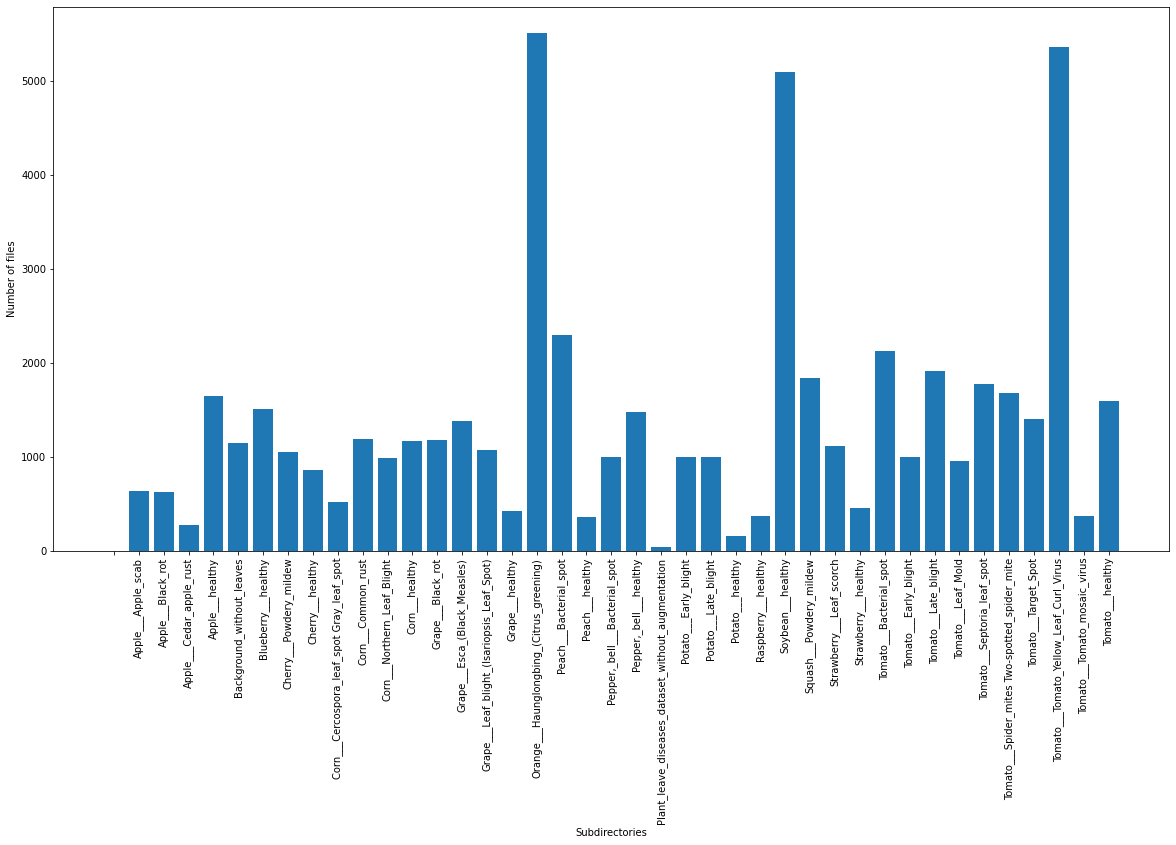

In [4]:
import matplotlib.pyplot as plt
sorted_keys = sorted(dir_count.keys())
plt.figure(figsize=(20, 10))
plt.bar(sorted_keys, [dir_count[key] for key in sorted_keys])
plt.xticks(rotation=90)
plt.xlabel('Subdirectories')
plt.ylabel('Number of files')
#
plt.show()

## Pull out Images
The function "pull_out_images(nImages_per_directory)" scans a zip file and extracts a random selection of nImages_per_directory images.



In [5]:
from pathlib import Path
from zipfile import ZipFile
import random
"""
The script uses the ZipFile module to open the zip file specified by the zip_filepath and iterates through the directories.
For each directory name, it checks if the name contains a string from the dir_names list. 
If the directory includes one of the strings in dir_names, the script 
takes a random sample of 10 files from the directory and extracts them to the specified target directory.  The target directory will be identified as either 
healthy_target_dir or unhealthy_target_dir. The extracted files are also renamed to include the name of the plant species in the file name.

The zip file should be specified at zip_filepath, and the target directories for the healthy and unhealthy images should 
be specified at healthy_target_dir and unhealthy_target_dir respectively. The dir_names variable contains a list of names 
of the plant species to be considered.
"""


# specify the zip file and the target directory
def pull_out_images(nImages_per_directory):
    zip_filepath = '/gdrive/MyDrive/Colab_datasets/Plant_leaf_diseases_dataset_without_augmentation.zip'
    healthy_target_dir = '/content/drgrowbuddy/healthy/'
    unhealthy_target_dir = '/content/drgrowbuddy/unhealthy/'
    # Path.mkdir('/content/healthy')
    dir_names = ["Apple","Grape","Pepper,_bell","Potato","Raspberry","Soybean","Strawberry"]
    # open the zip file
    with ZipFile(zip_filepath, 'r') as zip_ref:
        # iterate through the directories within the zip file
        for directory in (f for f in zip_ref.namelist() if f.endswith('/')):
          # Check if the directory name contains both an entry from the dir_names list as well as the word "healthy"
          if any(name in directory for name in dir_names):
            files = zip_ref.namelist()
            files = [file for file in files if directory in file]
            # take a random sample of files from the directory.
            files = random.sample(files,nImages_per_directory)
            dir_path = Path(directory)
            subdir_name = dir_path.parts[-1]
            for name in dir_names:
              if name in subdir_name:
                  short_dir_name = name
                  break

            for file in files:
                zip_info = zip_ref.getinfo(file)
                zip_info.filename = zip_info.filename.replace("image",short_dir_name)
                zip_info.filename = Path(zip_info.filename).name
                if "healthy" in directory:
                  target_dir = healthy_target_dir
                else:
                  target_dir = unhealthy_target_dir
                zip_ref.extract(zip_info, target_dir)


pull_out_images(10)


## Show images
PyTorch uses PIL image format. So let's use the PIL() class to randomly show one of the images we grabbed from calling "pull_out_images(10)".


There are a total of 169 images.
-------------------------
Fruit name:  Potato
Class:       healthy
Image size:  (256, 256)
Image mode:  RGB


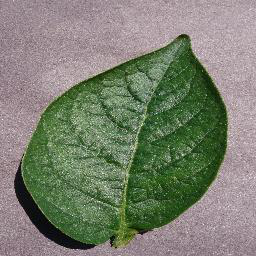

In [25]:
from pathlib import Path
import random
from PIL import Image

# setup
healthy_dir = Path('/content/drgrowbuddy/healthy')
unhealthy_dir = Path('/content/drgrowbuddy/unhealthy')
# Get the list of filepaths
images_list = list(healthy_dir.glob('*.JPG')) + list(unhealthy_dir.glob('*.JPG'))
print(f"There are a total of {len(images_list)} images.")
chosen_image_path = random.choice(images_list)
file_name = chosen_image_path.parts[-1]
dir_names = ["Apple","Grape","Pepper,_bell","Potato","Raspberry","Soybean","Strawberry"]
fruit_name = [name for name in dir_names if name in file_name][0]
image = Image.open(chosen_image_path)
class_name = chosen_image_path.parent.stem
print("-------------------------")
# dir_names = ["Apple","Grape","Pepper,_bell","Potato","Raspberry","Soybean","Strawberry"]
#  # Can use matplotlib to show or just show by typing image on a line, e.g.: plt.imshow(image)
print("Fruit name: ", fruit_name)
print("Class:      ", class_name)
print("Image size: ", image.size)
print("Image mode: ", image.mode)
image

In [ ]:
from pathlib import Path

image_path = Path('/content/drgrowbuddy')
image_paths = list(image_path.glob("*/*.JPG"))
len(image_paths)

167

1. Turn images into Tensors (to be used by PyTorch)
2. Turn it into a `torch.utils.data.Dataset` and subsequently a `torch.utils.data.Dataloader` (generator).

In [ ]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
# Write the transform for an image.
data_transform = transforms.Compose([
    # Resize the images to 64x64
    transforms.Resize(size=(224,224)),
    # Flip the images randomly on the horizontal
    transforms.RandomHorizontalFlip(p=0.5), # p = probability of flip, 0.5 = 50% chance
    # Turn the image into a torch.Tensor
    transforms.ToTensor() # this also converts all pixel values from 0 to 255 to be between 0.0 and 1.0 
])


In [ ]:
data_transform(image).shape

torch.Size([3, 224, 224])

In [ ]:
def plot_transformed_images(image_paths, transform, n=3, seed=42):
    """Plots a series of random images from image_paths.

    Will open n image paths from image_paths, transform them
    with transform and plot them side by side.

    Args:
        image_paths (list): List of target image paths. 
        transform (PyTorch Transforms): Transforms to apply to images.
        n (int, optional): Number of images to plot. Defaults to 3.
        seed (int, optional): Random seed for the random generator. Defaults to 42.
    """
    random.seed(seed)
    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(1, 2)
            ax[0].imshow(f) 
            ax[0].set_title(f"Original \nSize: {f.size}")
            ax[0].axis("off")

            # Transform and plot image
            # Note: permute() will change shape of image to suit matplotlib 
            # (PyTorch default is [C, H, W] but Matplotlib is [H, W, C])
            transformed_image = transform(f).permute(1, 2, 0) 
            ax[1].imshow(transformed_image) 
            ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
            ax[1].axis("off")

            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)


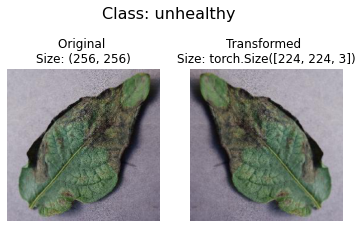

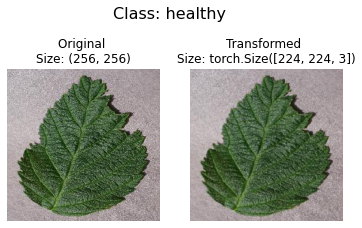

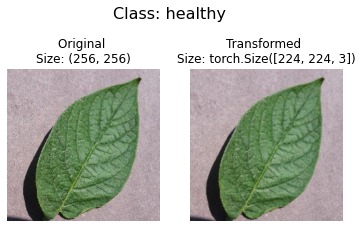

In [ ]:
plot_transformed_images(image_paths, data_transform, n=3, seed=42)

In [ ]:
# Use imagefolder to create the PyTorch dataset (TorchVision)
from torchvision import datasets

dataset = datasets.ImageFolder(root='/content/drgrowbuddy', transform = data_transform, target_transform=None)
dataset

Dataset ImageFolder
    Number of datapoints: 167
    Root location: /content/drgrowbuddy
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )

In [ ]:
classnames = dataset.classes
classdict = dataset.class_to_idx
print(f"Classnames: {classnames} index: {classdict}")
dataset.samples[0]

Classnames: ['healthy', 'unhealthy'] index: {'healthy': 0, 'unhealthy': 1}


('/content/drgrowbuddy/healthy/Apple (1007).JPG', 0)

In [ ]:
dataset[1][1]

0

In [ ]:
# Index on the dataset to get a single image and label.
# dataset[0] contains both the data for the first image as well as the label.
# dataset[0][0] is the data (image) and dataset[0][1] is the label of the first image.
img, label = dataset[0][0], dataset[0][1]
print(f"Image tensor:\n{img}")
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")
print(f"Label name: {classnames[label]}")

Image tensor:
tensor([[[0.5725, 0.6118, 0.6039,  ..., 0.6549, 0.6196, 0.6078],
         [0.7333, 0.7137, 0.6471,  ..., 0.7569, 0.6510, 0.5843],
         [0.6118, 0.6275, 0.7137,  ..., 0.5490, 0.5647, 0.5373],
         ...,
         [0.8902, 0.8980, 0.8980,  ..., 0.8745, 0.8824, 0.8784],
         [0.8980, 0.9059, 0.9059,  ..., 0.8745, 0.8745, 0.8627],
         [0.8980, 0.9020, 0.8941,  ..., 0.8824, 0.8667, 0.8510]],

        [[0.5176, 0.5569, 0.5490,  ..., 0.5922, 0.5569, 0.5451],
         [0.6784, 0.6588, 0.5922,  ..., 0.6941, 0.5882, 0.5216],
         [0.5569, 0.5725, 0.6588,  ..., 0.4863, 0.5020, 0.4745],
         ...,
         [0.8706, 0.8784, 0.8784,  ..., 0.8549, 0.8627, 0.8588],
         [0.8784, 0.8863, 0.8863,  ..., 0.8549, 0.8549, 0.8431],
         [0.8784, 0.8824, 0.8745,  ..., 0.8627, 0.8471, 0.8314]],

        [[0.5765, 0.6157, 0.6078,  ..., 0.6353, 0.6000, 0.5882],
         [0.7373, 0.7176, 0.6510,  ..., 0.7373, 0.6314, 0.5647],
         [0.6157, 0.6314, 0.7176,  ..., 0.52

Original shape: torch.Size([3, 224, 224]) -> [color_channels, height, width]
Image permute shape: torch.Size([224, 224, 3]) -> [height, width, color_channels]


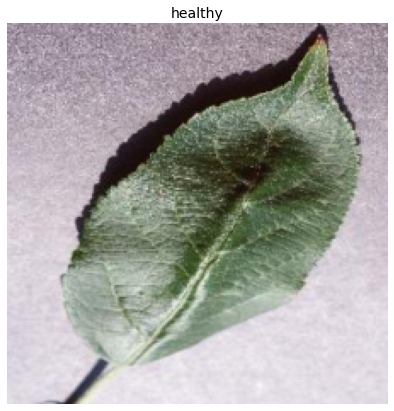

In [ ]:

# Rearrange the order of dimensions
img_permute = img.permute(1, 2, 0)

# Print out different shapes (before and after permute)
print(f"Original shape: {img.shape} -> [color_channels, height, width]")
print(f"Image permute shape: {img_permute.shape} -> [height, width, color_channels]")

# Plot the image
plt.figure(figsize=(10, 7))
plt.imshow(img.permute(1, 2, 0))
plt.axis("off")
plt.title(classnames[label], fontsize=14);